# Adidas Store Customer Reviews - Results

This notebook summarizes all of the exploration, modeling and results from the previous three notebooks. You can read more in depth about the steps in the notebooks for the respective section.

# The dataset

The dataset consists of scraped reviews from Google Maps of adidas stores within Germany.
The stores are in Herzo, Munich, Nuremberg, Frankfurt and Berlin. They consits of "Outlets", "Originals", "Terrex" and regular stores. 

Lets import the metadata

In [2]:
# Read review_metadata_sentiment.csv from the dataset folder

import pandas as pd

from PIL import Image
import IPython.display as display


metadata_df = pd.read_csv('dataset/review_metadata_sentiment.csv')

metadata_df[['store','num_ratings','num_reviews','star_rating']]

,store,num_ratings,num_reviews,star_rating
0,Herzo Store,8776,2201,4.2
1,Herzo Outlet,2365,1091,4.2
2,Nuremberg Store,763,288,4.3
3,Munich Outlet,450,210,4.3
4,Munich Terrex Store,102,68,4.7
5,Frankfurt Store,786,324,4.1
6,Berlin Store Originals,1293,681,4.1
7,Competitor Outlet,6533,2008,4.4


We can see in the data that the stores in Herzo have the most reviews. The highest rated store is the Terrex Store in Munich, but it also has the least reviews.

The last row is Competitor Outlet, which also has a significant number of reviews, this represents the competitor's outlet store in Herzo. In the future we can explore and compare the reviews, sentiment and topic models of the adidas Herzo outlet vs. the competitors outlet. 

## Sentiment Analysis and Results

After running a sentiment analysis model (refer to notebook 02) we extracted the number of negative, neutral and positive reviews for each store.

We attempt to reconstruct the star rating by weight the setiment as negative = 1, neutral = 3, and positive = 5. After we averaged these numbers we get a column called `sentiment_star_rating`. 

This rating is very similar to the original `star_rating` in most of the stores, and indicates that the sentiment analysis generates good results and highly correlates with the `star_rating`.


In [3]:
metadata_df

,store,num_ratings,num_reviews,star_rating,negative,neutral,positive,sentiment_star_rating
0,Herzo Store,8776,2201,4.2,446,149,1605,4.051795
1,Herzo Outlet,2365,1091,4.2,230,68,785,3.995417
2,Nuremberg Store,763,288,4.3,40,16,231,4.315972
3,Munich Outlet,450,210,4.3,20,17,172,4.433333
4,Munich Terrex Store,102,68,4.7,7,1,60,4.558824
5,Frankfurt Store,786,324,4.1,58,24,240,4.104938
6,Berlin Store Originals,1293,681,4.1,120,51,506,4.116006
7,Competitor Outlet,6533,2008,4.4,234,102,1661,4.404880


Now we will visualize the ratio of the sentiments for each store.

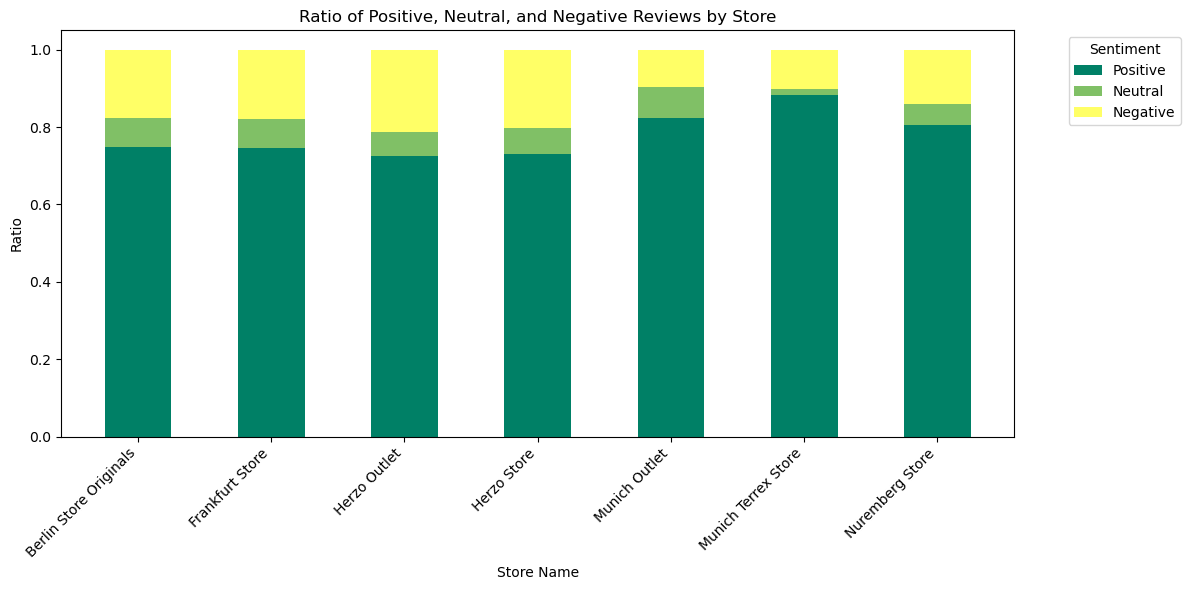

In [5]:
image_path = 'visualizations/sentiment_by_store.png'
display.display(Image.open(image_path))


They are all pretty much the same, with an exeption of the Munich stores which have a smaller proportion of negative reviews.

Next, let's visualize the sentiment over the years. Here, we can also see a line indicating the ratio of negative reviews per year.

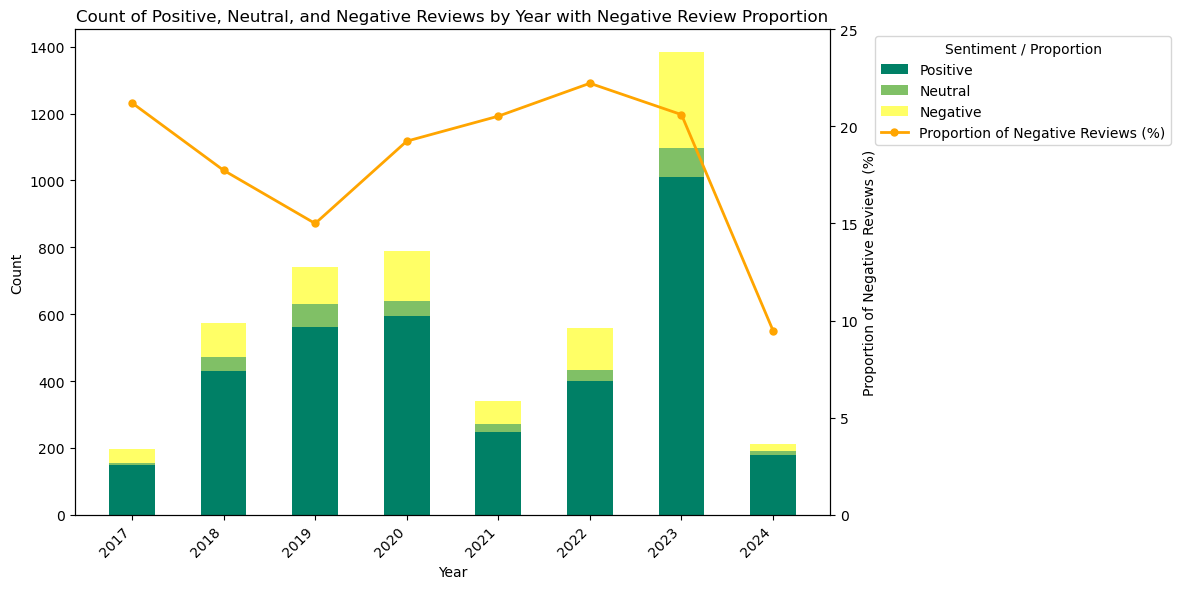

In [6]:
image_path = 'visualizations/sentiment_by_year.png'
display.display(Image.open(image_path))


Observe that during 2021 and 2022, the number of reviews have drastically dropped compared to the previous years. Also the proportion of negative reviews increase in these years.

In 2023 we have the most reviews of all years, and the large yellow bar indicates that there are also more negative reviews than any other year. However, as shown by the orange line, the proportion of negative reviews in 2023 has actually dropped compared to the previous year.

## Topic Clustering with Large Language Models

To better understand the opinions and feedback of the customers, we can analyze the reviews and group them in clusters.
The first step is to just run the BERTopic topic clustering algorithm on the whole dataset. The results are below:

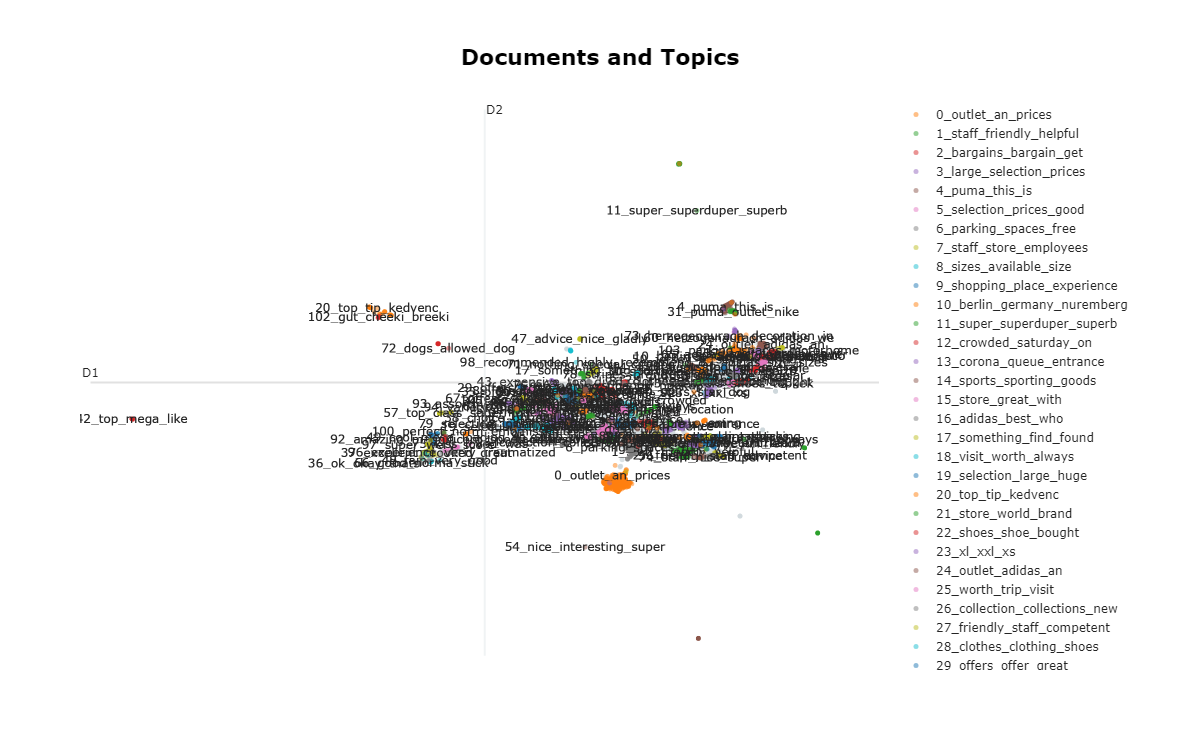

In [7]:
image_path = 'visualizations/initial_clustering.png'
display.display(Image.open(image_path))


These results look very messy and are difficult to interpret. We have observed the following issues and potential ways to solve them.

* There are many clusters that are just the same one or two words. 
    * Let's remove reviews shorter than 3 words.
* There are too many clusters for the model to be interpretable.
    * We will tune the hyperparamters of each algorithm and upgrade the embedding model. 
* The data from adidas and the competitor mix in and create uniterpretable clusters.
    * We will split the adidas data and only cluster this data, to understand the reviews for adidas first.


* The clusters have names that are not easy to understand
    * We are going to upgrade the representation model to use KeyBERT and LLMs
* Reviews with positive and negative sentiment are getting mixed up in the same cluster.
    * We can split the data by sentiment and cluster it in that form.
    * This will give us titles of the clusters which will also indicate the sentiment.
    * Ex. instead of getting a cluster `Customer Service` we could get clusters `Good Customer Service` and `Bad Customer Service`.

### Positive Sentiment
After splitting the data according to sentiment, tuning the model and upgrading the representation to use an improved embedding model, we get much better results. First, we will look at the clusters for the positive sentiment. If you want to see more details on how this is done, refer to notebook 03.

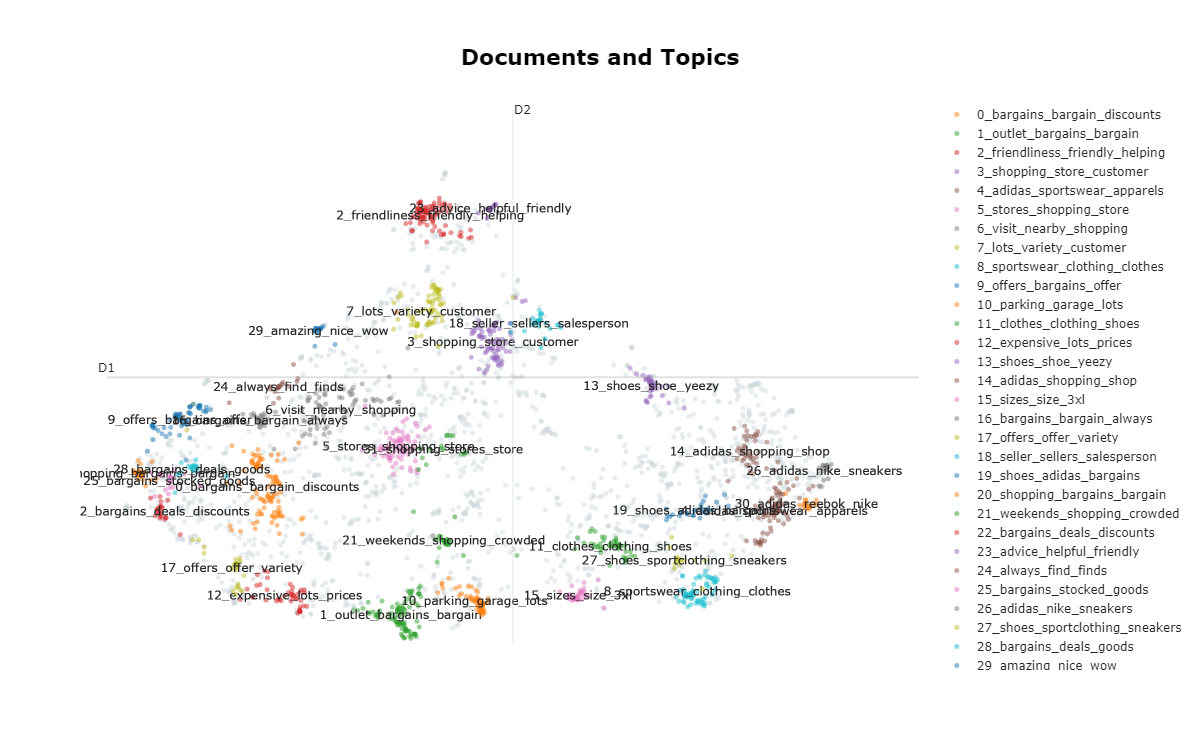

In [8]:
image_path = 'visualizations/positive_initial.png'
display.display(Image.open(image_path))


We can notice and understand many of the clusters straight away now. 
Ex. 0_bargains_bargain_discounts indicate that consumers are happy about the offers and discounts on the products in the adidas stores,
2_friendliness_friendly_helping is probably refering to customer service and that the employees have a friendly attitude towards the consumers.

While these clusters are much better, we can notice that some of them are very similar to each other. For example 0, 1, 9 and 16 all discuss bargains and offers. 

Let's merge the clusters a bit to have more interpretable results and reduce duplicates.




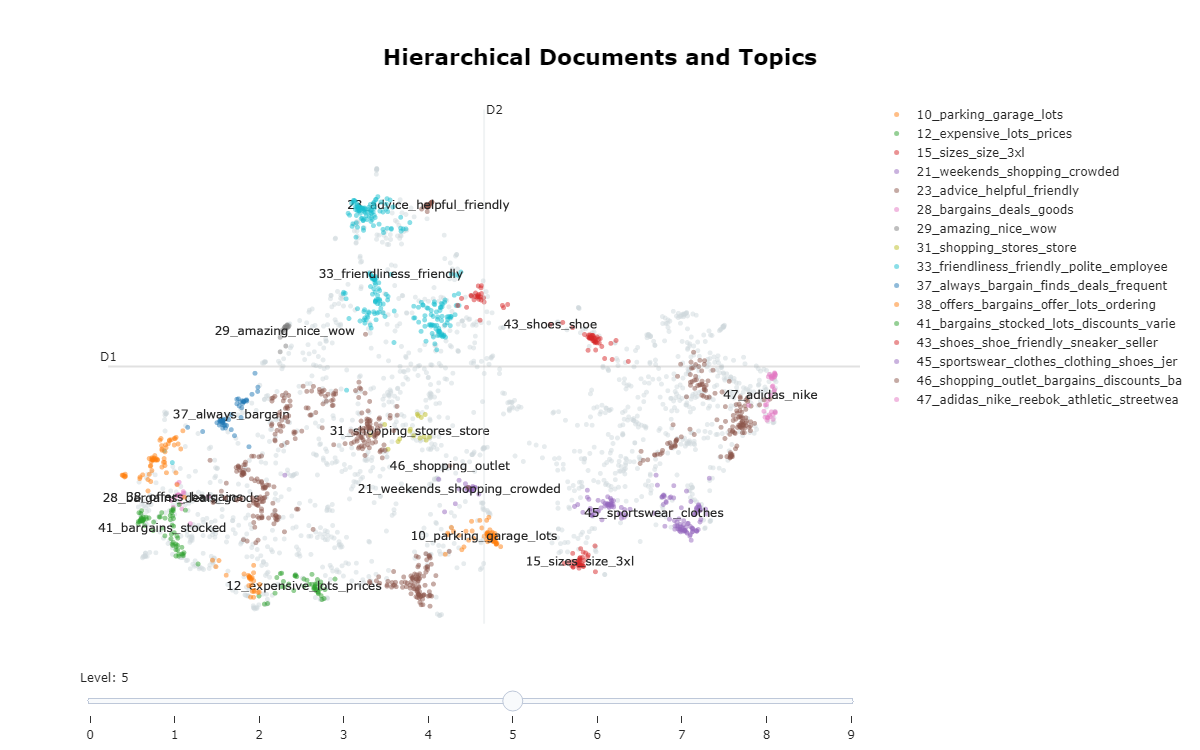

In [9]:
image_path = 'visualizations/positive_reduced_lvl5.png'
display.display(Image.open(image_path))


After implementing hierachical topic reduction and setting it at level 5 we see more coherent topics that do not repeat as often. The slider below allows us to modify the strength of the merging (currently set to 5).

Some of the topics we can notice are regarding: 10 - parking, 15 - available sizing, 33 - friendly and polite employees, and 38 - bargains and discounts.

### Negative Sentiment

Now let's look at the clusters with negative sentiment and observe what are the main things that we need to improve in the stores. 

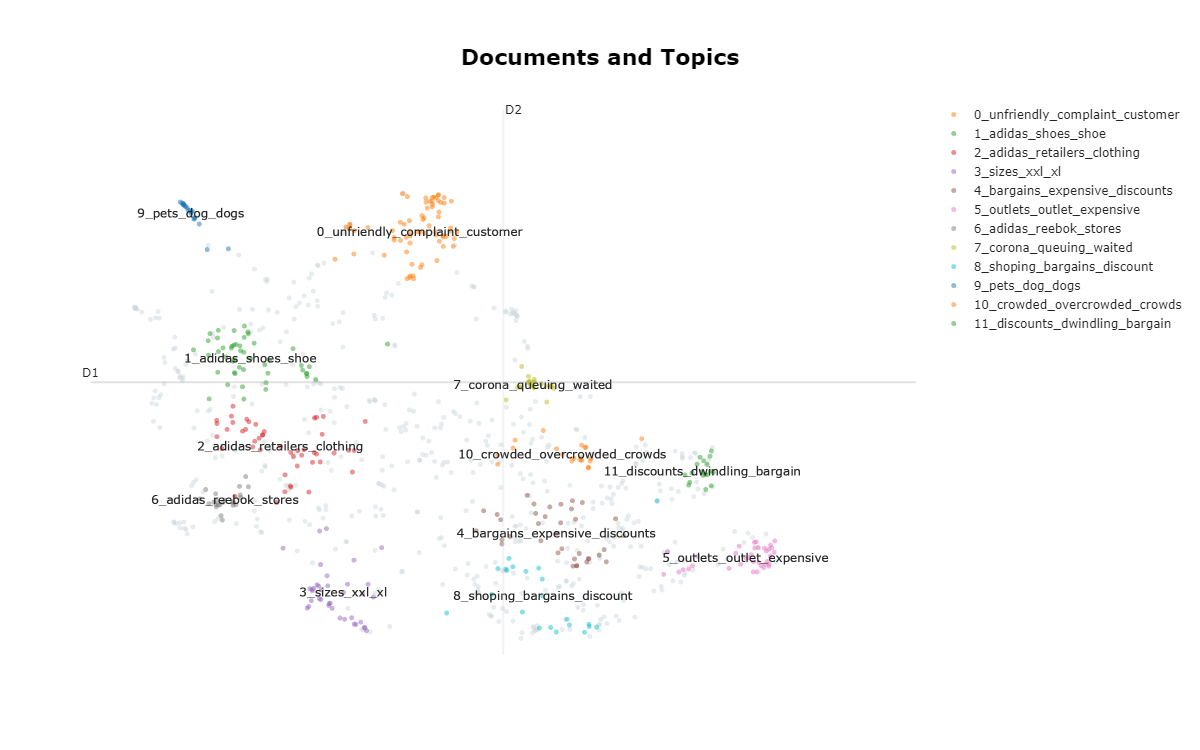

In [10]:
image_path = 'visualizations/negative_initial.png'
display.display(Image.open(image_path))


There are less negative reviews, and thus less clusters. They seem quite clear in the visualization. 0 - Unfriendly Staff, 7 - Corona Queuing, 11 - Dwindling Discounts. 

While now we know the top 3 words that describe these clusters, we cannot really understand what they are exactly about. 
For example, what is cluster 9_pets_dog_dogs about? Are people complaining that there are too many dogs in the stores?

Let's use a Large Language Model to look at some of the reviews and give us a better title for these clusters.


### Naming with Large Language Models - Mixtral-8x7B 

We used an open source model named Mixtral-8x7B which outperforms ChatGPT-3.5 Turbo in many benchmarks and even comes close to GPT-4 in some. 

The main advantage is that it can be ran locally on our own machines, or hosted on a 3rd party machine for cheaper than the ChatGPT models. 

Let's look at the results:


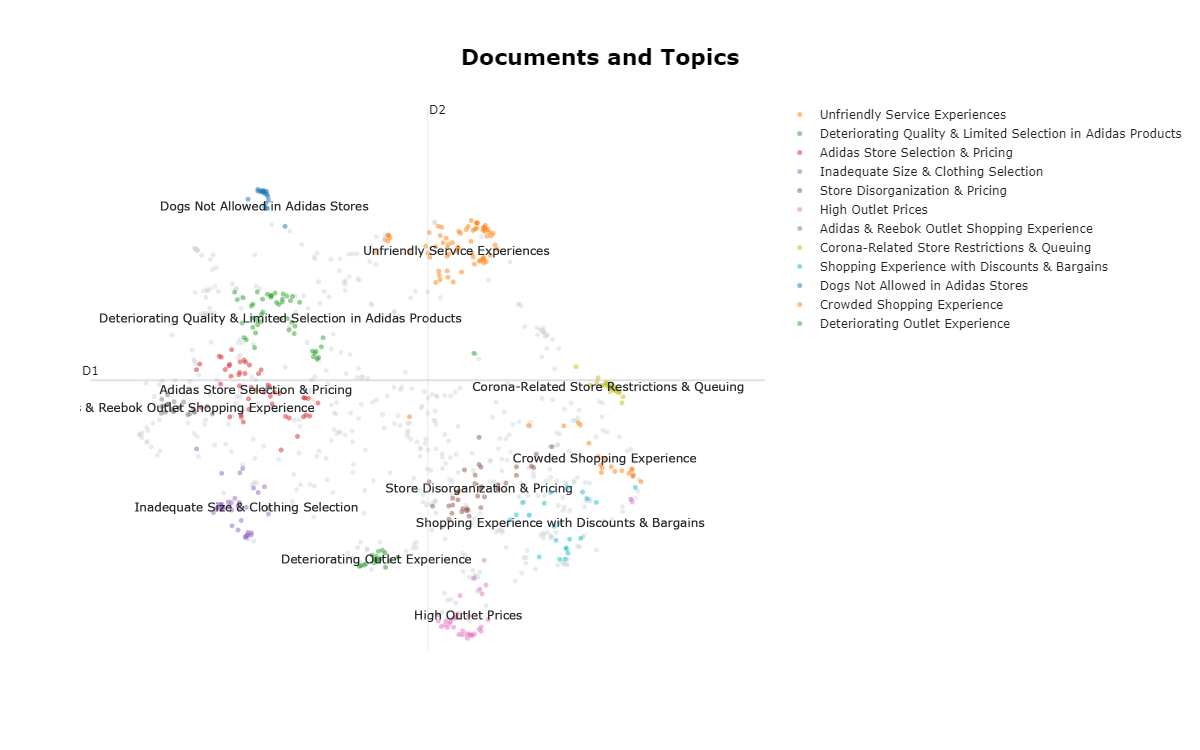

In [11]:
image_path = 'visualizations/negative_new_titles.png'
display.display(Image.open(image_path))


Now we have a much clearer picture of what the main complaints in the stores are. We know that the 9th topic is actually about dogs *not* being allowed in the stores.

### Topics Over Time

Finally, let's look at how the popularity of these topics develops over the years. With this analysis we will be able to detect whether a topic has always been popular, or has it significantly grown in recent times.


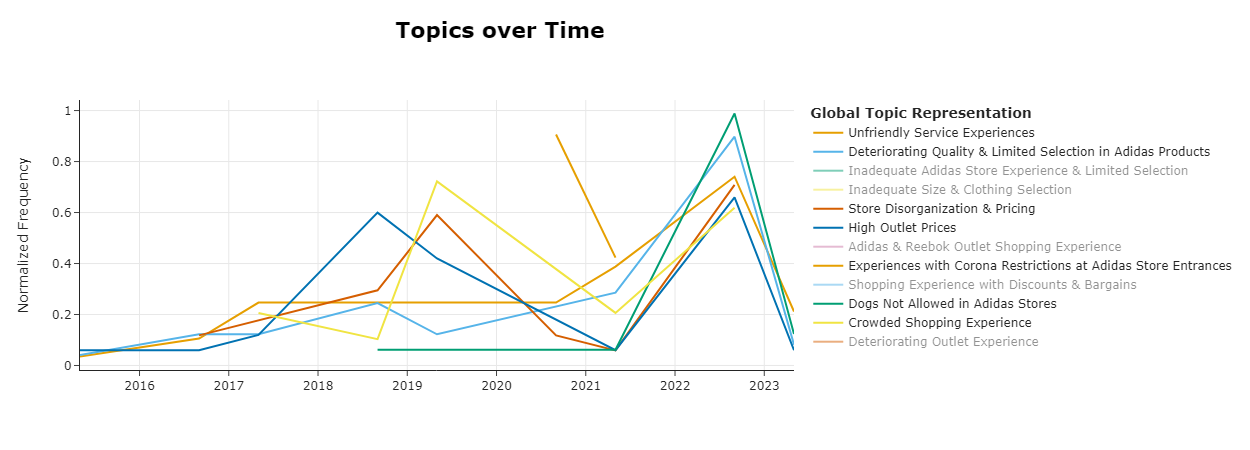

In [12]:
image_path = 'visualizations/negative_over_time_new_titles_filtered.png'
display.display(Image.open(image_path))


We visualized the frequency of the topics over time and removed some of the topics from the visualization for easier interpretation.
If we look at the dark green topic of `Dogs Not Allowed in Adidas Stores` we can notice that this topic was almost non-existent until 2022. This means that probably, there was a change in store policy which banned dogs around that time.

Similarly, we can see the orange topic that is just a short line above 2021 -  `Experiences with Corona Restrictions at Adidas Store Entrances` is a topic only present in that year. Which is expected since this is when the Corona Regulations were in force.

I hope that this short demonstration of how we can use Topic Clustering and Sentiment analysis has sparked some interest and ideas on how this can be applied on internal adidas data, as well. 

I believe that this can directly be used on product reviews on the adidas online store, and we could quickly gather insight on what are the main positives and drawbacks of certain product categories. Both overall and in specific intervals over time.
